In [62]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from IPython.display import Image
from PIL import Image
import io
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [63]:
# Mount to Google Drive so images in Drive can be accessed by Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
data = pd.read_csv('depop_item_details_complete.csv')
data = data.drop(columns=['Image', 'Date', 'Location'])
data.head()

,Description,Price listed,Price sold,Size,Brand
0,🌫️ Vintage hot pink sweater 🌫️ ▫️ Stretchy hot...,US$20.00,US$11.00,M,Cache
1,🌫️ Wool pencil skirt 🌫️ ▫️ Grey wool fabric sh...,US$15.00,US$4.50,4,Ralph Lauren
2,🌫️ Green and Black corset🌫️ ▫️ Gorge iridescen...,US$14.00,US$7.00,30,Other
3,🌫️ Vintage denim mini skirt 🌫️ ▫️ Lighter weig...,US$20.00,US$6.00,6,Calvin Klein
4,🌫️ Wide leg y2k pants 🌫️ ▫️ Thick black fabric...,US$20.00,US$14.00,8,American Vintage


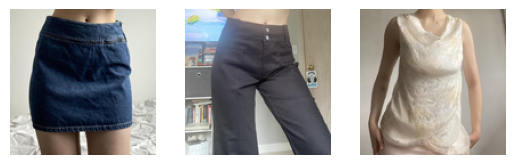

In [65]:
indices = np.array(data.index)

plt.figure()
# For each image, retrieve RGB matrix from Google Drive
for i in indices[3:6]:

    # Open the JPEG file
    rgb_matrix = np.load("/content/drive/MyDrive/depop_images/depop_image_" + str(i) + ".npy")
    # Append matrix to image list
    image = Image.fromarray(np.uint8(rgb_matrix))
    # Display the image in the notebook
    plt.subplot(1, 3, i-2)
    plt.imshow(image)
    plt.axis('off')  # Turn off axis labels

In [79]:
def pricing(price):
  try:
    return float(price.replace('US$', ''))
  except ValueError:
    return price

data['Price listed'] = data['Price listed'].apply(pricing)
data['Price sold'] = data['Price sold'].apply(pricing)

In [80]:
def sizing(size):
  try:
    size = float(size)
    if size <= 4:
      return 'XS'

    elif size <= 8 or size == 26:
      return 'S'

    elif size <= 12:
      return 'M'

    elif size <= 16 or size == 30:
      return 'L'

    else:
      return 'XL'

  except ValueError:
    if 'US ' in size:
      size = size.replace('US ', '')

      try:
        return sizing(float(size))

      except ValueError:
        return size

    else:
      return size

data['Size'] = data['Size'].apply(sizing)


In [68]:
import torchvision.transforms as transforms

# Define transform function to convert image to tensor of proper dimensions
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

input_images = []

for i in indices:
  rgb_matrix = np.load("/content/drive/MyDrive/depop_images/depop_image_" + str(i) + ".npy")
  input_images.append(transform(rgb_matrix))

data['Image'] = input_images

In [81]:
data['Image'] = input_images

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert descriptions to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
description_vectors = vectorizer.fit_transform(data['Description'])

# Convert the sparse matrix to a dense format (e.g., numpy array)
description_vectors = description_vectors.toarray()

# Add the vectors to the DataFrame (optional, but for ease of access)
data['Description'] = list(description_vectors)

In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['Price listed'] = scaler.fit_transform(data['Price listed'].values.reshape(-1, 1))

data = pd.get_dummies(data, columns=['Size', 'Brand'])

In [93]:
class DepopDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

        # Apply astype(int) for one-hot encoded columns before passing to the dataset
        self.size_columns = dataframe.filter(like='Size').columns
        self.brand_columns = dataframe.filter(like='Brand').columns

        # Convert True/False to 0/1 (should be done during data prep)
        self.dataframe[self.size_columns] = self.dataframe[self.size_columns].astype(int)
        self.dataframe[self.brand_columns] = self.dataframe[self.brand_columns].astype(int)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Extract image, description, and numerical data
        image = torch.tensor(self.dataframe['Image'].iloc[idx], dtype=torch.float32)  # Image as tensor
        description = torch.tensor(self.dataframe['Description'].iloc[idx], dtype=torch.float32)  # Description

        # Extract price, size, and brand (now as integers)
        price_listed = torch.tensor([self.dataframe['Price listed'].iloc[idx]], dtype=torch.float32)

        # Extract one-hot encoded size and brand columns
        size = torch.tensor(self.dataframe[self.size_columns].iloc[idx].values, dtype=torch.float32)
        brand = torch.tensor(self.dataframe[self.brand_columns].iloc[idx].values, dtype=torch.float32)

        # Concatenate all inputs together
        combined_input = torch.cat([image.view(-1), description.view(-1), price_listed, size, brand], dim=0)

        # Label is the price sold (or modify as per your needs)
        label = torch.tensor(self.dataframe['Price sold'].iloc[idx], dtype=torch.float32)

        return combined_input, label


In [133]:
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame with the necessary columns

# Step 1: Split the dataset into training + validation and test sets
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)  # 80% train/validation, 20% test

# Step 2: Split the training + validation into training and validation sets
train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)  # 60% train, 20% val (of the original data)

# Step 3: Create Dataset instances for each split
train_dataset = DepopDataset(train_data)
val_dataset = DepopDataset(val_data)
test_dataset = DepopDataset(test_data)

batch_size = 10

# Step 4: Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Now you can use train_loader, val_loader, and test_loader in your training and evaluation processes.
# Verify dimensions of each dataset
train_inputs, train_labels = next(iter(train_loader))
val_inputs, val_labels = next(iter(val_loader))
test_inputs, test_labels = next(iter(test_loader))
print("Dimensions of train data: ", train_inputs.shape)
print("Dimensions of validation data: ", val_inputs.shape)
print("Dimensions of test data: ", test_inputs.shape)

<ipython-input-93-75bff370011d>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.dataframe['Image'].iloc[idx], dtype=torch.float32)  # Image as tensor


Dimensions of train data:  torch.Size([10, 50314])
Dimensions of validation data:  torch.Size([10, 50314])
Dimensions of test data:  torch.Size([10, 50314])


In [126]:
# Check a batch from the train loader
for inputs, labels in test_loader:
    print("Inputs shape:", inputs.shape)  # This should be [batch_size, input_size]
    print("Labels shape:", labels.shape)  # This should be [batch_size]
    break  # Stop after the first batch

<ipython-input-93-75bff370011d>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.dataframe['Image'].iloc[idx], dtype=torch.float32)  # Image as tensor


Inputs shape: torch.Size([32, 50314])
Labels shape: torch.Size([32])


In [103]:
# Initialize Training Loss and Validation Accuracy list
train_loss_list = []
val_accuracy_list = []

In [104]:
# Step 1: Define the Neural Network Architecture
class DepopPriceNN(nn.Module):
    def __init__(self, input_size):
        super(DepopPriceNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 64)           # Second hidden layer
        self.fc3 = nn.Linear(64, 1)             # Output layer (price)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)               # No activation for regression output
        return x

# Determine the input size based on your combined input shape
input_size = 128*128*3 + 1000 + 1 + 15 + 146  # Adjust these values based on your actual feature sizes

# Step 3: Initialize the Model, Loss Function, and Optimizer
model = DepopPriceNN(input_size)  # Initialize the model
criterion = nn.MSELoss()                # Loss function for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer

# Step 5: Training Loop with Validation
num_epochs = 10  # Set the number of epochs for training
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        train_loss_list.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels.view(-1, 1)).item()

        val_accuracy_list.append(val_loss / len(val_loader))

    avg_val_loss = val_loss / len(val_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

# After training, you can evaluate the model on the test set similarly.


<ipython-input-93-75bff370011d>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.dataframe['Image'].iloc[idx], dtype=torch.float32)  # Image as tensor


Epoch [1/10], Train Loss: 116.8247
Epoch [1/10], Validation Loss: 122.7422
Epoch [2/10], Train Loss: 40.7720
Epoch [2/10], Validation Loss: 133.1313
Epoch [3/10], Train Loss: 48.0074
Epoch [3/10], Validation Loss: 140.2613
Epoch [4/10], Train Loss: 39.6362
Epoch [4/10], Validation Loss: 155.3782
Epoch [5/10], Train Loss: 26.9256
Epoch [5/10], Validation Loss: 123.9593
Epoch [6/10], Train Loss: 32.6351
Epoch [6/10], Validation Loss: 146.0918
Epoch [7/10], Train Loss: 14.6280
Epoch [7/10], Validation Loss: 148.5883
Epoch [8/10], Train Loss: 9.2520
Epoch [8/10], Validation Loss: 162.1751
Epoch [9/10], Train Loss: 24.6316
Epoch [9/10], Validation Loss: 142.6688
Epoch [10/10], Train Loss: 37.5500
Epoch [10/10], Validation Loss: 167.4125


Text(0.5, 0, 'Epochs')

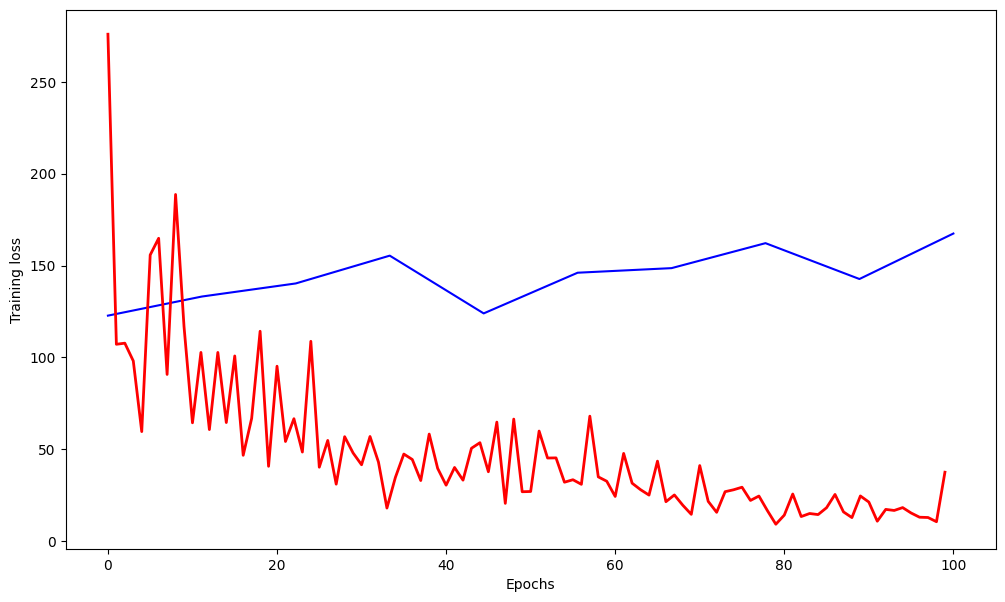

In [108]:
# Plots the training loss and validation accuracy
plt.figure(figsize = (12, 7))
plt.plot(np.linspace(0, 100, 10), val_accuracy_list, color = 'blue')
plt.plot(train_loss_list, linewidth = 2, color = 'red')
plt.ylabel("Training loss")
plt.xlabel("Epochs")

In [134]:
# Step 6: Testing the Neural Network
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
predictions = []
actuals = []

with torch.no_grad():  # No need to compute gradients during testing
    for test_inputs, test_labels in test_loader:  # Use the test DataLoader
        test_outputs = model(test_inputs)  # Get model predictions
        loss = criterion(test_outputs, test_labels.view(-1, 1))  # Calculate test loss
        test_loss += loss.item()  # Accumulate test loss

        # Save predictions and actual labels for further evaluation
        predictions.extend(test_outputs.cpu().numpy())
        actuals.extend(test_labels.cpu().numpy())

# Average test loss over the entire test dataset
avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.4f}')

<ipython-input-93-75bff370011d>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.dataframe['Image'].iloc[idx], dtype=torch.float32)  # Image as tensor


Test Loss: 137.4851


In [127]:
val_outputs.shape

torch.Size([3, 1])

In [137]:
test_inputs.shape

torch.Size([9, 50314])

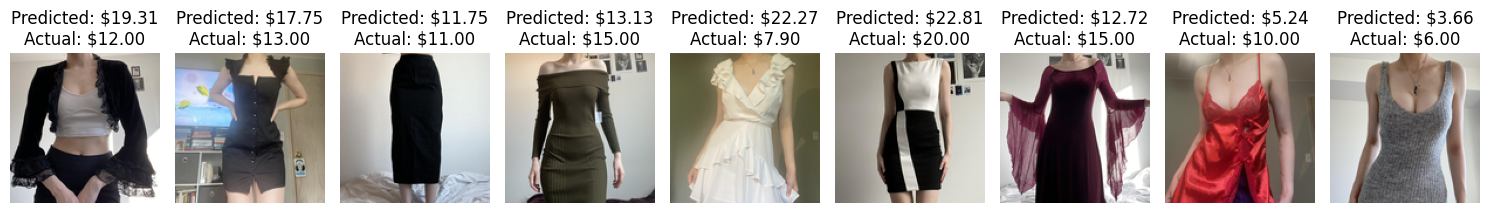

In [143]:
# Assuming predictions and actuals are already defined
# Make sure predictions and actuals are the same size
# Check the length of actuals
num_samples = len(test_inputs)  # Adjust based on how many you want to see

# Sample indices from the range of actuals
real_values = actuals[:num_samples]
predicted_values = predictions[:num_samples]

# Plotting

# Define the mean and std values used for normalization
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# Function to reverse normalization
def reverse_normalize(tensor):
    return tensor * std[:, None, None] + mean[:, None, None]

plt.figure(figsize=(15, 10))

for i, input  in enumerate(test_inputs):
    image_tensor = input[:128*128*3]  # Extract the features for the idx
    image = image_tensor.view(3, 128, 128)  # Reshape to (C, H, W)
    image = reverse_normalize(image)  # Apply reverse normalization
    actual_price = real_values[i].item()  # Ensure it's a scalar
    predicted_price = predicted_values[i].item()  # Ensure it's a scalar

    # Transpose to HxWxC for visualization
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC for plt.imshow

    # Plotting
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(image)  # Display the image
    plt.axis('off')  # Hide axes
    plt.title(f'Predicted: ${predicted_price:.2f}\nActual: ${actual_price:.2f}')  # Show prices

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
